# BERT Spam Classification using Tensorflow

Try to classify spam messages using BERT and Tensorflow.

Credit to : https://www.analyticsvidhya.com/blog/2021/12/text-classification-using-bert-and-tensorflow/

In [1]:
import sys
!{sys.executable} -m pip install tensorflow-text==2.8.1
!{sys.executable} -m pip install scikit-learn==1.3.1

In [2]:
import pandas as pd

df = pd.read_csv("data/SMSSpamCollection", sep="\t", names=["label", 'message'])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Convert label ham and spam into binary values 0 and 1

In [3]:
df['spam'] = df['label'].apply(lambda x: 1 if x == "spam" else 0)
df.head()

,label,message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


171


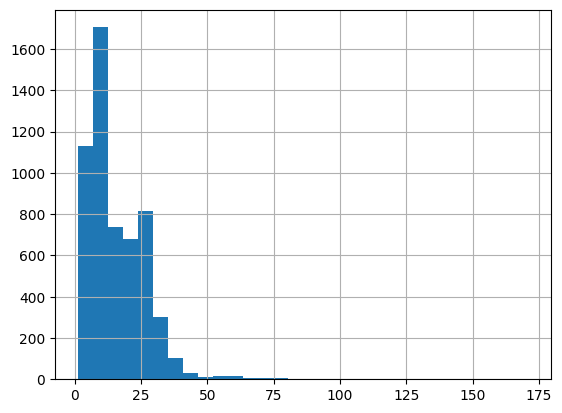

In [4]:
seq_len = [len(i.split()) for i in df.message]

pd.Series(seq_len).hist(bins=30)
max_seq_len = max(seq_len)
print(max_seq_len)

- **Split dataset into train and test using `train_test_split`.**  
- Using stratified sampling to ensure that train and test have equal proportion of `ham` and `spam`. 
- Stratified sampling is a method of sampling from a population which can be partitioned into subpopulations.


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.message, df.spam, stratify=df.spam)

# print to make sure no data leakage
# what is data leakage? https://machinelearningmastery.com/data-leakage-machine-learning/
# in summary, data leakage is when information from outside the training dataset is used to create the model
# which means the model will not be able to generalize well to new data
# how the information from outside the training dataset is used to create the model?
# in this case, the information is the test dataset
# if we use the test dataset to create the model, then the model will not be able to generalize well to new data
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

4568    But you were together so you should be thinkin...
1456    Summers finally here! Fancy a chat or flirt wi...
2080                          I can take you at like noon
3422    Welcome! Please reply with your AGE and GENDER...
3390                        O. Guess they both got screwd
Name: message, dtype: object

- **We need to tokenize the text data using bert_preprocess.** 
- After text data tokenized, then we will encode it using bert_encoder

In [6]:
import tensorflow as tf 
import tensorflow_hub as hub 
import tensorflow_text as text

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

2023-10-15 01:54:12.585615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-15 01:54:12.585889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-15 01:54:12.609740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-15 01:54:12.610003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-15 01:54:12.610211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

- **Sentence embedding is to convert the text input into a vector.**
- Transformer or BERT not able to process raw data, it needs to be converted into a vector.
- We will use bert_encoder to convert the text input into a vector.
- its return pooled_output which is [CLS] token embedding and sequence_output which is embedding of all tokens in BERT
- Imagine CLS token is try to make single representation over all the input text 

In [7]:
def get_sentence_embedding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    encoded_text = bert_encoder(preprocessed_text)
    return encoded_text['pooled_output']

get_sentence_embedding(["$500 discount. Hurry up!", "Bhavin, are you up for volley game tomorrow?"])

2023-10-15 01:54:20.436365: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8814409 , -0.4795407 , -0.92536545, ..., -0.7865841 ,
        -0.75873065,  0.91710496],
       [-0.8657644 , -0.48833352, -0.93009543, ..., -0.85933286,
        -0.72032976,  0.8754201 ]], dtype=float32)>

- **We create a new layer for input and output.**
- Input layer is scalar () and type is string that support UTF-8
- Output layer from bert encoder
- We create Dropout layer to prevent overfitting
- One dense layer for sigmoid activation function

In [8]:
# Bert layer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# neural network
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(l)

# use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

- Trainable params is weights that will be updated during training
- Non-trainable params is not updated


- We choose `adam` as optimizer which SGD extension. Its common and popular optimizer.
- `Adam` will adjust the learning rate automatically.
- We choose `binary_crossentropy` as loss function because we have binary classification problem.
- The success metrics is accuracy (there are another like F1, Precision, Recall, etc)

In [9]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, batch_size=48)

Epoch 1/5


88/88 [==============================] - 16s 137ms/step - loss: 0.3389 - accuracy: 0.8619
Epoch 2/5
88/88 [==============================] - 12s 138ms/step - loss: 0.2558 - accuracy: 0.8808
Epoch 3/5
88/88 [==============================] - 12s 137ms/step - loss: 0.2203 - accuracy: 0.9048
Epoch 4/5
88/88 [==============================] - 12s 131ms/step - loss: 0.1927 - accuracy: 0.9239
Epoch 5/5
88/88 [==============================] - 12s 131ms/step - loss: 0.1796 - accuracy: 0.9306


- Evaluating the model using test data and print the accuracy

In [10]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 3s 70ms/step - loss: 0.1615 - accuracy: 0.9354


[0.1614852100610733, 0.9353912472724915]

- Using the trained model to predict the test data
- The difference with evaluation, its not seeing the label (truth)

In [11]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
print(y_predicted)

[0.09859416 0.05266986 0.02638505 ... 0.32614058 0.01080248 0.00347597]


- **The result prediction is not clear spam or not spam**
- We converting with whatever value more than 0.5 considered as spam

In [12]:
import numpy as np 

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted


array([0, 0, 0, ..., 0, 0, 0])